<a href="https://colab.research.google.com/github/C00ldudeNoonan/financial-conditions-index/blob/main/Economic_Financial_Index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
import requests
import pandas as pd
import requests
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import matplotlib.dates as mdates
import matplotlib.font_manager as fm

pd.set_option('display.max_columns', None)

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)


from google.colab import userdata
apiKey = userdata.get('fredKey')


In [69]:
spreadsheetId = '1k8qnFgKx3xk4CCp55m1zPrZaiulSBHRpE9_BlfeCy2M'


url = 'https://github.com/C00ldudeNoonan/financial-conditions-index/raw/main/EBGaramond-Medium.ttf'
response = requests.get(url)

with open('EBGaramond-Medium.ttf', 'wb') as f:
    f.write(response.content)


fm.fontManager.addfont('EBGaramond-Medium.ttf')

In [70]:
def fetchData(apiKey):

    url = f"https://api.stlouisfed.org/fred/series/observations?series_id=BAMLH0A0HYM2&api_key={apiKey}&file_type=json&"

    response = requests.get(url)
    bondData = response.json()

    bondDf = pd.DataFrame(bondData['observations'])
    bondDf['series'] = 'High Yeild Bond Rate'
    bondDf = bondDf.drop(columns=['realtime_start', 'realtime_end'])
    bondDf['date'] = pd.to_datetime(bondDf['date'])
    bondDf['value'] = pd.to_numeric(bondDf['value'], errors='coerce')
    bondDf.set_index('date', inplace=True)
    bondDf.sort_index(inplace=True)
    bondDf['90_day_avg'] = bondDf['value'].rolling('90D', min_periods=1).mean()
    bondDf.reset_index(drop=False, inplace=True)
    bondDf['month'] = bondDf['date'].dt.month
    bondDf['day'] = bondDf['date'].dt.day
    bondDf['year'] = bondDf['date'].dt.year
    bondDf = bondDf.groupby(['year', 'month']).apply(lambda x: x[x['day'] == x['day'].max()])
    bondDf.reset_index(drop=True, inplace=True)
    bondDf.drop(columns=['value', 'month', 'day', 'year'], inplace=True)
    bondDf['diff'] = bondDf['90_day_avg'] - bondDf['90_day_avg'].shift(3)
    bondDf['date'] = bondDf['date'] + pd.offsets.MonthEnd(0)

    # Reset index to make 'date' and 'series' columns
    bondDf.reset_index(inplace=True)

    dowUrl = f"https://api.stlouisfed.org/fred/series/observations?series_id=DJIA&api_key={apiKey}&file_type=json&"

    response = requests.get(dowUrl)
    dowData = response.json()

    dowDf = pd.DataFrame(dowData['observations'])
    dowDf['series'] = 'Dow Jones Industrial Average'
    dowDf = dowDf.drop(columns=['realtime_start', 'realtime_end'])
    dowDf = pd.DataFrame(dowDf)
    dowDf['date'] = pd.to_datetime(dowDf['date'])
    print(len(dowDf))
    # Compute log levels
    dowDf['value'] = pd.to_numeric(dowDf['value'], errors='coerce')
    dowDf.dropna(subset=['value'], inplace=True)
    dowDf['month'] = dowDf['date'].dt.month
    dowDf['day'] = dowDf['date'].dt.day
    dowDf['year'] = dowDf['date'].dt.year
    dowDf['log_price'] = np.log(dowDf['value'])
    # print(spyDf[(spyDf['month']==3) & (spyDf['year']==2024)])
    dowDf = dowDf.groupby(['year', 'month']).apply(lambda x: x[x['day'] == x['day'].max()])
    dowDf.reset_index(drop=True, inplace=True)

    dowDf['log_diff_90'] = (np.log(dowDf['value'])-np.log(dowDf['value'].shift(3)))*100
    dowDf['date'] = dowDf['date'] + pd.offsets.MonthEnd(0)
    # feds fund rate

    fedsFundUrl = f"https://api.stlouisfed.org/fred/series/observations?series_id=MORTGAGE30US&api_key={apiKey}&file_type=json&"

    response = requests.get(fedsFundUrl)
    fedsFundData = response.json()

    fedsFundDf = pd.DataFrame(fedsFundData['observations'])
    fedsFundDf['series'] = 'Fed Funds Rate'
    fedsFundDf = fedsFundDf.drop(columns=['realtime_start', 'realtime_end'])
    fedsFundDf['date'] = pd.to_datetime(fedsFundDf['date'])
    fedsFundDf['value'] = pd.to_numeric(fedsFundDf['value'], errors='coerce')
    fedsFundDf.set_index('date', inplace=True)
    fedsFundDf.sort_index(inplace=True)
    fedsFundDf['90_day_avg'] = fedsFundDf['value'].rolling('90D', min_periods=1).mean()
    fedsFundDf.reset_index(drop=False, inplace=True)
    fedsFundDf['month'] = fedsFundDf['date'].dt.month
    fedsFundDf['day'] = fedsFundDf['date'].dt.day
    fedsFundDf['year'] = fedsFundDf['date'].dt.year
    fedsFundDf = fedsFundDf.groupby(['year', 'month']).apply(lambda x: x[x['day'] == x['day'].max()])
    fedsFundDf.reset_index(drop=True, inplace=True)
    fedsFundDf.drop(columns=['value', 'month', 'day', 'year'], inplace=True)
    fedsFundDf['date'] = fedsFundDf['date'] + pd.offsets.MonthEnd(0)
    fedsFundDf['diff'] = fedsFundDf['90_day_avg'] - fedsFundDf['90_day_avg'].shift(3)
    fedsFundDf['date'] = fedsFundDf['date'] + pd.offsets.MonthEnd(0)

    # ten year yield
    tenYearUrl = f"https://api.stlouisfed.org/fred/series/observations?series_id=DGS10&api_key={apiKey}&file_type=json&"

    response = requests.get(tenYearUrl)
    tenYearData = response.json()

    tenYearDf = pd.DataFrame(tenYearData['observations'])
    tenYearDf['series'] = '10 Year Treasury Yeild'
    tenYearDf = tenYearDf.drop(columns=['realtime_start', 'realtime_end'])
    tenYearDf['date'] = pd.to_datetime(tenYearDf['date'])
    tenYearDf['value'] = pd.to_numeric(tenYearDf['value'], errors='coerce')
    tenYearDf.set_index('date', inplace=True)
    tenYearDf.sort_index(inplace=True)
    tenYearDf['90_day_avg'] = tenYearDf['value'].rolling('90D', min_periods=1).mean()
    tenYearDf.reset_index(drop=False, inplace=True)
    tenYearDf['month'] = tenYearDf['date'].dt.month
    tenYearDf['day'] = tenYearDf['date'].dt.day
    tenYearDf['year'] = tenYearDf['date'].dt.year
    tenYearDf = tenYearDf.groupby(['year', 'month']).apply(lambda x: x[x['day'] == x['day'].max()])
    tenYearDf.reset_index(drop=True, inplace=True)
    tenYearDf.drop(columns=['value', 'month', 'day', 'year'], inplace=True)
    tenYearDf['date'] = tenYearDf['date'] + pd.offsets.MonthEnd(0)
    tenYearDf['diff'] = tenYearDf['90_day_avg'] - tenYearDf['90_day_avg'].shift(3)
    tenYearDf['date'] = tenYearDf['date'] + pd.offsets.MonthEnd(0)


    # mortgage rates
    mortgageUrl = f"https://api.stlouisfed.org/fred/series/observations?series_id=MORTGAGE30US&api_key={apiKey}&file_type=json&"

    response = requests.get(mortgageUrl)
    mortgageData = response.json()

    mortgageDf = pd.DataFrame(mortgageData['observations'])
    mortgageDf['series'] = '30 year Mortgage Rate'
    mortgageDf = mortgageDf.drop(columns=['realtime_start', 'realtime_end'])
    mortgageDf['date'] = pd.to_datetime(mortgageDf['date'])
    # Convert 'date' column to last day of the month
    mortgageDf['value'] = pd.to_numeric(mortgageDf['value'], errors='coerce')
    mortgageDf.set_index('date', inplace=True)
    mortgageDf.sort_index(inplace=True)
    mortgageDf['90_day_avg'] = mortgageDf['value'].rolling('90D', min_periods=1).mean()
    mortgageDf.reset_index(drop=False, inplace=True)
    mortgageDf['month'] = mortgageDf['date'].dt.month
    mortgageDf['day'] = mortgageDf['date'].dt.day
    mortgageDf['year'] = mortgageDf['date'].dt.year
    mortgageDf = mortgageDf.groupby(['year', 'month']).apply(lambda x: x[x['day'] == x['day'].max()])
    mortgageDf.reset_index(drop=True, inplace=True)
    mortgageDf.drop(columns=['value', 'month', 'day', 'year'], inplace=True)
    mortgageDf['date'] = mortgageDf['date'] + pd.offsets.MonthEnd(0)
    mortgageDf['diff'] = mortgageDf['90_day_avg'] - mortgageDf['90_day_avg'].shift()
    mortgageDf['date'] = mortgageDf['date'] + pd.offsets.MonthEnd(0)

    # zillow index

    zillowUrl = f"https://api.stlouisfed.org/fred/series/observations?series_id=USAUCSFRCONDOSMSAMID&api_key={apiKey}&file_type=json&"

    response = requests.get(zillowUrl)
    zillowData = response.json()

    zillowDf = pd.DataFrame(zillowData['observations'])
    zillowDf['series'] = 'Zillow House Index'
    zillowDf = zillowDf.drop(columns=['realtime_start', 'realtime_end'])
    zillowDf = pd.DataFrame(zillowDf)
    zillowDf['date'] = pd.to_datetime(zillowDf['date'])
    # Compute log levels
    zillowDf['value'] = pd.to_numeric(zillowDf['value'], errors='coerce')
    zillowDf.dropna(subset=['value'], inplace=True)
    zillowDf['month'] = zillowDf['date'].dt.month
    zillowDf['day'] = zillowDf['date'].dt.day
    zillowDf['year'] = zillowDf['date'].dt.year
    zillowDf['log_price'] = np.log(zillowDf['value'])
    # print(spyDf[(spyDf['month']==3) & (spyDf['year']==2024)])
    zillowDf = zillowDf.groupby(['year', 'month']).apply(lambda x: x[x['day'] == x['day'].max()])
    zillowDf.reset_index(drop=True, inplace=True)

    zillowDf['log_diff_90'] = (np.log(zillowDf['value'])-np.log(zillowDf['value'].shift(3)))*100
    zillowDf['date'] = zillowDf['date'] + pd.offsets.MonthEnd(0)


    # dollar index
    dollarUrl = f"https://api.stlouisfed.org/fred/series/observations?series_id=DTWEXBGS&api_key={apiKey}&file_type=json&"

    response = requests.get(dollarUrl)
    dollarData = response.json()

    dollarDf = pd.DataFrame(dollarData['observations'])
    dollarDf['series'] = 'Dollar Index'
    dollarDf = dollarDf.drop(columns=['realtime_start', 'realtime_end'])
    dollarDf['date'] = pd.to_datetime(dollarDf['date'])

    dollarDf['value'] = pd.to_numeric(dollarDf['value'], errors='coerce')
    dollarDf.set_index('date', inplace=True)
    dollarDf.sort_index(inplace=True)
    dollarDf['90_day_avg'] = dollarDf['value'].rolling('90D', min_periods=1).mean()
    dollarDf.reset_index(drop=False, inplace=True)
    dollarDf['month'] = dollarDf['date'].dt.month
    dollarDf['day'] = dollarDf['date'].dt.day
    dollarDf['year'] = dollarDf['date'].dt.year
    dollarDf = dollarDf.groupby(['year', 'month']).apply(lambda x: x[x['day'] == x['day'].max()])
    dollarDf.reset_index(drop=True, inplace=True)
    dollarDf.drop(columns=['value', 'month', 'day', 'year'], inplace=True)
    dollarDf['date'] = pd.to_datetime(dollarDf['date'])
    dollarDf['diff'] = np.log(dollarDf['90_day_avg'] - dollarDf['90_day_avg'].shift(3))
    dollarDf['diff'].fillna(0, inplace=True)
    dollarDf['date'] = dollarDf['date'] + pd.offsets.MonthEnd(0)


    # data cleanup for merging
    dowDf['equity'] = dowDf['log_diff_90']
    zillowDf['housing'] = zillowDf['log_diff_90']
    dollarDf['dollar'] = dollarDf['diff']
    bondDf['tripleb'] = bondDf['diff']
    mortgageDf['mortgage'] = mortgageDf['diff']
    tenYearDf['10yr'] = tenYearDf['diff']
    fedsFundDf['FFR'] = fedsFundDf['diff']
    print('dow min date', dowDf['date'].min())
    print('zillow max date', zillowDf['date'].min())
    print('dollar min date', dollarDf['date'].min())
    print('bond min date', bondDf['date'].min())
    print('mortgage min date', mortgageDf['date'].min())
    print('10 year min date', tenYearDf['date'].min())
    print('fed funds min date', fedsFundDf['date'].min())
    dowDf = dowDf[dowDf['date'] > '2014-04-30 00:00:00'].sort_values(by='date', ascending=True)
    bondDf = bondDf[bondDf['date'] > '2014-04-30 00:00:00'].sort_values(by='date', ascending=True)
    mortgageDf = mortgageDf[mortgageDf['date'] > '2014-04-30 00:00:00'].sort_values(by='date', ascending=True)
    zillowDf = zillowDf[zillowDf['date'] > '2014-04-30 00:00:00'].sort_values(by='date', ascending=True)
    dollarDf = dollarDf[dollarDf['date'] > '2014-04-30 00:00:00'].sort_values(by='date', ascending=True)
    tenYearDf = tenYearDf[tenYearDf['date'] > '2014-04-30 00:00:00'].sort_values(by='date', ascending=True)
    fedsFundDf = fedsFundDf[fedsFundDf['date'] > '2014-04-30 00:00:00'].sort_values(by='date', ascending=True)

    dowDf.drop(columns=['series','month', 'day', 'year', 'value', 'log_price', 'log_diff_90'], inplace=True)
    zillowDf.drop(columns=['series','month', 'day', 'year','value', 'log_price', 'log_diff_90'], inplace=True)
    bondDf.drop(columns=['index', 'series',  '90_day_avg', 'diff'], inplace=True)
    mortgageDf.drop(columns=['series', '90_day_avg', 'diff'], inplace=True)
    dollarDf.drop(columns=['series', '90_day_avg', 'diff'], inplace=True)
    tenYearDf.drop(columns=['series', '90_day_avg', 'diff'], inplace=True)
    fedsFundDf.drop(columns=['series', '90_day_avg', 'diff'], inplace=True)
    merged_df = pd.merge(dowDf, bondDf, on='date', how='inner')
    print("equities")
    merged_df = pd.merge(merged_df, mortgageDf, on='date', how='inner')
    print("bond")
    merged_df = pd.merge(merged_df, zillowDf, on='date', how='inner')
    print("zillow")
    merged_df = pd.merge(merged_df, dollarDf, on='date', how='inner')
    print("dollar")
    merged_df = pd.merge(merged_df, tenYearDf, on='date', how='inner')
    print("10yr")
    merged_df = pd.merge(merged_df, fedsFundDf, on='date', how='inner')
    print("fed funds")

    return merged_df


# Define the data
weights = {
    'period': list(range(4, 17)),
    'FFR': [0.099943944, 0.068578534, 0.050928985, 0.030388756, 0.025687511,
            0.020009094, 0.015811759, 0.011351882, 0.007392853, 0.003964395,
            0.001711082, 0.000393424, 0.000128902],
    '10yr': [-0.008148666, -0.014000342, -0.018387348, -0.021524343, -0.023217226,
             -0.024365968, -0.025223595, -0.025907416, -0.026403294, -0.02669953,
             -0.020122033, -0.013446104, -0.006723265],
    'mortgage': [0.217427793, 0.14524869, 0.119052555, 0.077495153, 0.062434293,
                 0.045143184, 0.03369689, 0.02483504, 0.018457125, 0.013733173,
                 0.008657804, 0.004898748, 0.002101614],
    'tripleb': [0.079267719, 0.091179148, 0.098643896, 0.100472542, 0.10064806,
                0.099579542, 0.097660772, 0.09535261, 0.092766486, 0.090084434,
                0.066538625, 0.043675043, 0.021503906],
    'equity': [-0.021318565, -0.020215983, -0.018436156, -0.016157903, -0.014443706,
               -0.01302431, -0.011752768, -0.010660868, -0.009703574, -0.008865985,
               -0.006342937, -0.004042458, -0.001937252],
    'housing': [-0.03222844, -0.031273991, -0.029701866, -0.026759405, -0.019779925,
                -0.013423982, -0.006051851, 0.000769171, 0.004236312, 0.006672419,
                0.007860665, 0.008861208, 0.009192217],
    'dollar': [0.048, 0.048, 0.045, 0.039, 0.031, 0.023, 0.017, 0.012, 0.008, 0.005, 0.002, 0, 0]
}

# Create DataFrame
weightsDf = pd.DataFrame(weights)

# Display DataFrame
print(weightsDf)


def weightcalc(window, variable):
    '''takes in a window of values and a variable and returns the adjusted sum
    '''
    weights = weightsDf[variable].to_list()[::-1]
    adjusted_values = [x * weight for x, weight in zip(window, weights)]
    # print(adjusted_values)
    adjusted_sum = sum(adjusted_values)
    return adjusted_sum

merged_df = fetchData(apiKey)
print(merged_df.columns)
merged_df['equity_score'] = merged_df['equity'].rolling(12).apply(lambda x: weightcalc(x, 'equity'))
merged_df['tripleb_score'] = merged_df['tripleb'].rolling(12).apply(lambda x: weightcalc(x, 'tripleb'))
merged_df['mortgage_score'] = merged_df['mortgage'].rolling(12).apply(lambda x: weightcalc(x, 'mortgage'))
merged_df['housing_score'] = merged_df['housing'].rolling(12).apply(lambda x: weightcalc(x, 'housing'))

merged_df['dollar_score'] = merged_df['dollar'].rolling(12).apply(lambda x: weightcalc(x, 'dollar'))
merged_df['10yr_score'] = merged_df['10yr'].rolling(12).apply(lambda x: weightcalc(x, '10yr'))
merged_df['FFR_score'] = merged_df['FFR'].rolling(12).apply(lambda x: weightcalc(x, 'FFR'))
merged_df['FCI'] = merged_df['equity_score'] + merged_df['tripleb_score'] + merged_df['mortgage_score'] + merged_df['housing_score'] + merged_df['dollar_score'] + merged_df['10yr_score'] + merged_df['FFR_score']

print(merged_df.tail())


    period       FFR      10yr  mortgage   tripleb    equity   housing  dollar
0        4  0.099944 -0.008149  0.217428  0.079268 -0.021319 -0.032228   0.048
1        5  0.068579 -0.014000  0.145249  0.091179 -0.020216 -0.031274   0.048
2        6  0.050929 -0.018387  0.119053  0.098644 -0.018436 -0.029702   0.045
3        7  0.030389 -0.021524  0.077495  0.100473 -0.016158 -0.026759   0.039
4        8  0.025688 -0.023217  0.062434  0.100648 -0.014444 -0.019780   0.031
5        9  0.020009 -0.024366  0.045143  0.099580 -0.013024 -0.013424   0.023
6       10  0.015812 -0.025224  0.033697  0.097661 -0.011753 -0.006052   0.017
7       11  0.011352 -0.025907  0.024835  0.095353 -0.010661  0.000769   0.012
8       12  0.007393 -0.026403  0.018457  0.092766 -0.009704  0.004236   0.008
9       13  0.003964 -0.026700  0.013733  0.090084 -0.008866  0.006672   0.005
10      14  0.001711 -0.020122  0.008658  0.066539 -0.006343  0.007861   0.002
11      15  0.000393 -0.013446  0.004899  0.043675 -

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


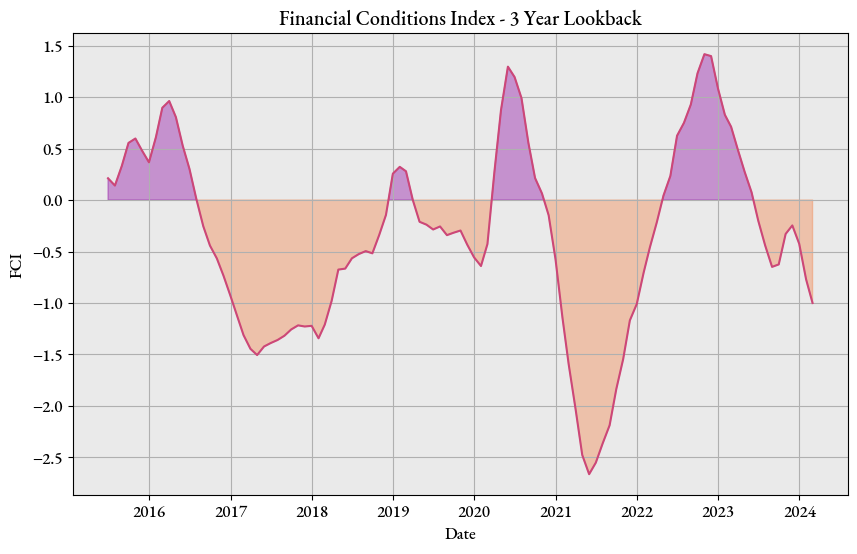

In [72]:

plt.figure(figsize=(10, 6))
plt.rcParams['font.family'] = 'EB Garamond'
plt.rcParams['font.size'] = 12

# Plot the FCI time series
plt.plot(merged_df['date'], merged_df['FCI'], color=plt.cm.plasma(0.5), linestyle='-')

# Fill the area between the line and zero with light blue if above zero, and light orange if below zero
plt.fill_between(merged_df['date'], merged_df['FCI'], where=(merged_df['FCI'] >= 0), color=plt.cm.plasma(0.3), alpha=0.4, interpolate=True)
plt.fill_between(merged_df['date'], merged_df['FCI'], where=(merged_df['FCI'] < 0), color=plt.cm.plasma(0.7), alpha=0.4, interpolate=True)
plt.gca().set_facecolor((0.8, 0.8, 0.8, 0.4))  # RGBA values: (R, G, B, Alpha)

plt.title('Financial Conditions Index - 3 Year Lookback')

plt.xlabel('Date')
plt.ylabel('FCI')
plt.grid(True)
plt.show()

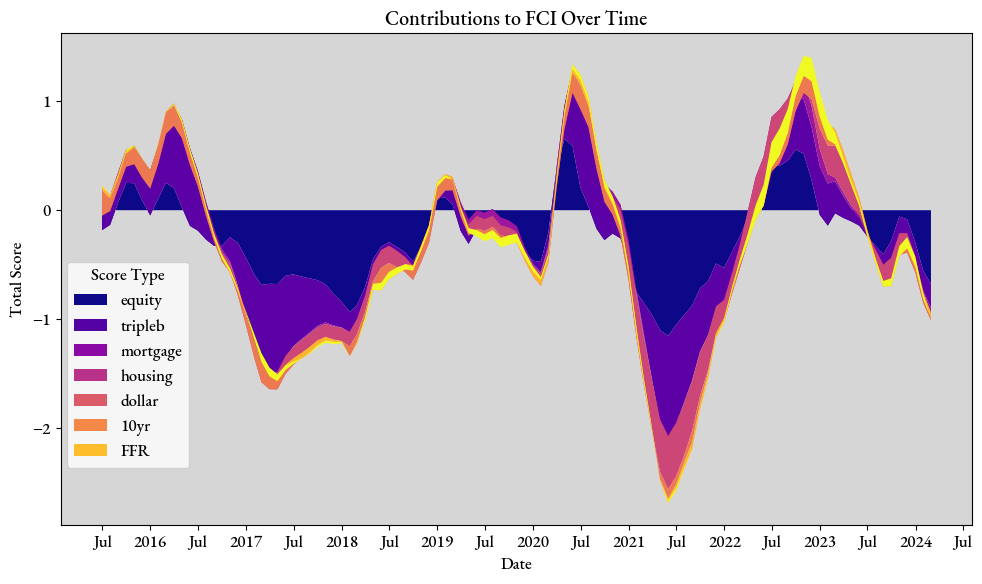

In [66]:
#Stacked bar chart

df = merged_df[['date', 'equity_score', 'tripleb_score'
                  , 'mortgage_score', 'housing_score', 'dollar_score', '10yr_score', 'FFR_score']]
df = df[df['date'] > '2015-04-30 00:00:00'].sort_values(by='date', ascending=True)
df.rename(columns={col: col.replace('_score', '') for col in df.columns}, inplace=True)
df.set_index('date', inplace=True)

fig, ax = plt.subplots(figsize=(10, 6))
# Define a list of jewel tone colors

ax.stackplot(df.index, df.T, colors=plt.cm.plasma(np.linspace(0, 1, len(df.columns))))
ax.set_facecolor((0.8, 0.8, 0.8, 0.8))  # RGBA values: (R, G, B, Alpha)

ax.set_title('Contributions to FCI Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Total Score')

# Create a MonthLocator instance for every half-year
months = mdates.MonthLocator(bymonth=[1, 7])

# Create a ConciseDateFormatter instance
date_fmt = mdates.ConciseDateFormatter(months)

# Set the major locator and formatter
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(date_fmt)


# Create a custom legend
legend_proxies = []
for i, column in enumerate(df.columns):
    legend_proxies.append(plt.Rectangle((0, 0), 1, 1, fc=plt.cm.plasma(i / len(df.columns))))

ax.legend(legend_proxies, df.columns, title='Score Type', loc='lower right', bbox_to_anchor=(0.15, 0.1))

plt.tight_layout()
plt.show()

In [ ]:
# Open the spreadsheet by its ID

spreadsheet = gc.open_by_key(spreadsheetId)
# Convert NaN or Infinity to a string representation
merged_df.replace([np.inf, -np.inf, np.nan], 'null', inplace=True)

# Convert DataFrame to a list of lists for writing to Google Sheets
df_values = merged_df.values.tolist()

# Convert all values to strings
df_values = [[str(val) for val in row] for row in df_values]

# Update Google Sheets
worksheet = spreadsheet.get_worksheet(0)  # Assuming you're updating the first worksheet
worksheet.clear()
worksheet.update([merged_df.columns.values.tolist()] + df_values)

worksheet = spreadsheet.get_worksheet(1)  # Index 0 corresponds to the first worksheet

# Clear existing data in Sheet 2 (optional)
worksheet.clear()

# Write DataFrame to Sheet 1 starting from cell A1
worksheet.update([weightsDf.columns.values.tolist()] + weightsDf.values.tolist())

{'spreadsheetId': '1k8qnFgKx3xk4CCp55m1zPrZaiulSBHRpE9_BlfeCy2M',
 'updatedRange': 'Sheet2!A1:H14',
 'updatedRows': 14,
 'updatedColumns': 8,
 'updatedCells': 112}